# Testing Notebook

**Note:** This Jupyter notebook is for testing and playing around with the data. It is not a final product. Let me know if you have problems with it in Github Issues.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns

In [47]:
multichoice = pd.read_csv('cleaned_multichoice.csv')
# print(multichoice.head())

## Correlation matrix
The first visualization, the correlation matrix, is used to find columns that relate to each other or *correlate*. This can help brainstorm ideas for future visualizations. My code below randomly chooses 10 columns from the cleaned data and analyzes the correlation.


You only need to look at the data under and to the left of the red squares as it is mirrored to the other side.

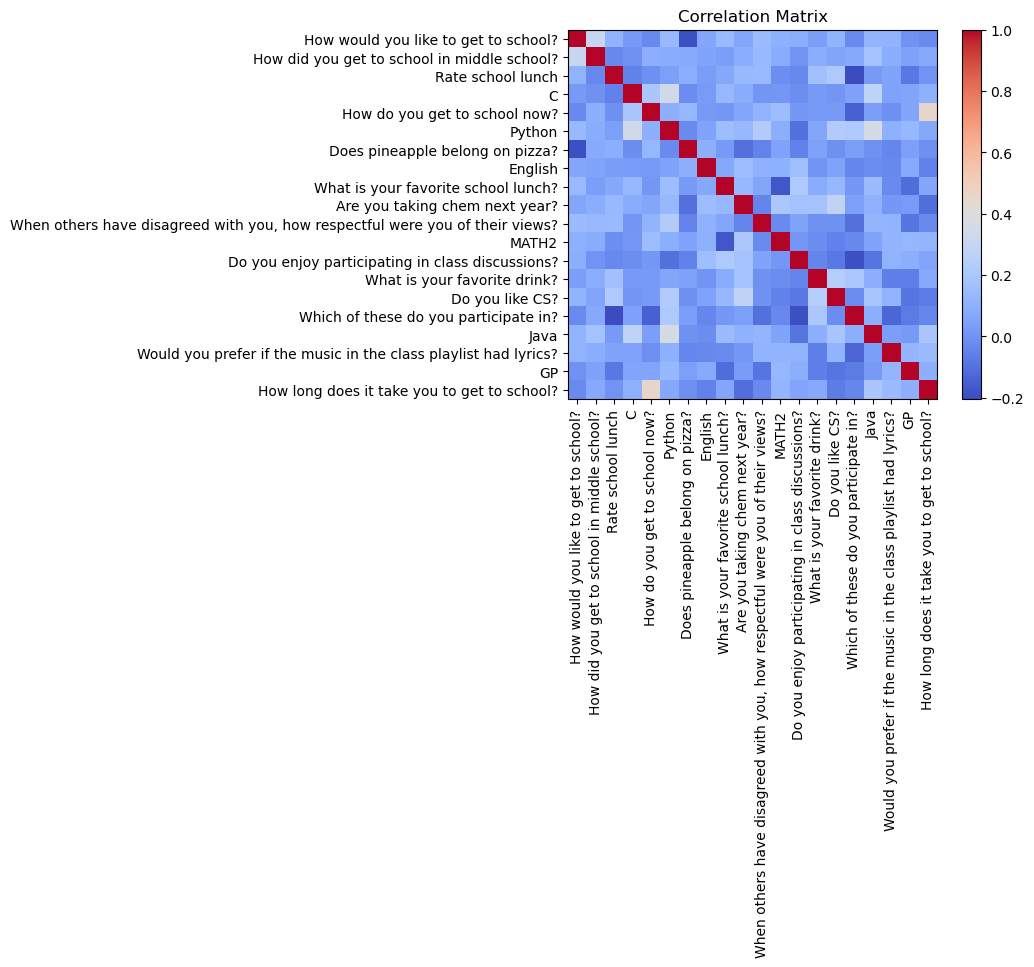

In [50]:
selected_columns = np.random.choice(
    multichoice.columns, size=20, replace=False)
random_multichoice = multichoice[selected_columns]
corr_matrix = random_multichoice.corr()

# Plotting the correlation matrix
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()